# NPZ Dataset Loader Test

이 노트북은 `.npz` 형식의 3D 의료 영상 데이터를 로드하고,  
`split.pkl` 기반의 DataLoader를 통해 샘플을 시각화하는 과정을 다룹니다.

### 주요 단계

1. `split.pkl` 기반 데이터 로더 생성  

2. 배치 데이터 확인 (shape, spacing 등)  

3. 중간 슬라이스 및 라벨 시각화

In [4]:
import sys, os

# 현재 노트북 기준으로 상위 경로로 이동하여 baseline/3DSAM-adapter 패키지 경로 추가
sys.path.append(os.path.abspath("../baseline/3DSAM-adapter"))

In [5]:
DATA_DIR = "./data/BiomedSegFM_4Tumor/3D_train_npz_all/CT/CT_ColonTumor"

### 0. split.pkl 생성

split ratio에 따라 데이터셋을 랜덤하게 분할하고, 해당 정보를 저장하는 `splip.pkl` 파일을 생성합니다. 

In [4]:
from dataset.make_split_pkl import make_split_pkl

SPLIT = make_split_pkl(
    data_dir=DATA_DIR,     # npz 폴더 경로
    split_ratio=(0.7, 0.1, 0.2),
    seed=42,
    relative_dir=""        # path_prefix 아래의 상대경로로 저장
)

✅ split.pkl saved at: ./data/BiomedSegFM_4Tumor/3D_train_npz_all/CT/CT_ColonTumor/split.pkl
 - Total: 114  | Train: 79  Val: 11  Test: 24


### 1. 테스트 데이터 로더 생성

`load_npz_data_volume()` 함수를 사용하여 `split.pkl`에 지정된 `test` 세트를 로드합니다.

- `path_prefix`: 데이터 루트 경로  

- `split`: train / val / test 중 선택  

- `deterministic`: 셔플 없이 고정 순서  

- `augmentation`: 데이터 증강 여부  

- `rand_crop_spatial_size`: 랜덤 크롭 크기  

In [12]:
# split.pkl 파일을 사용하여 테스트 데이터 로더 생성
from dataset.npz_dataloader import load_npz_data_volume

test_loader = load_npz_data_volume(
    path_prefix=DATA_DIR,
    split="test",
    batch_size=1,
    deterministic=True,
    augmentation=False,
    rand_crop_spatial_size=(96, 96, 96),
    do_test_crop=False,
    # do_test_crop=True, # >> 에러남 
    num_worker=0,
    file_list=None,   # split.pkl 사용
)

### 2. 로더 출력 구조 확인

아래 코드는 `DataLoader`에서 한 배치만 추출해  
입력 이미지(`imgs`), 마스크(`gts`), voxel spacing을 출력합니다.


In [13]:
for imgs, gts, spacing in test_loader:
    print(imgs.shape, gts.shape, spacing)  # imgs: (B, 3, D, H, W)
    break

torch.Size([1, 3, 10, 512, 512]) torch.Size([1, 10, 512, 512]) tensor([[0.7324, 0.7324, 5.0000]], dtype=torch.float64)


### 3. 샘플 시각화

- **중앙 슬라이스 오버레이**: gray-scale CT 이미지 위에 mask를 붉게 표시  

- **다중 슬라이스 그리드**: 여러 z-slice를 한눈에 보기  


1) 배치에서 꺼내서 중앙 슬라이스 시각화

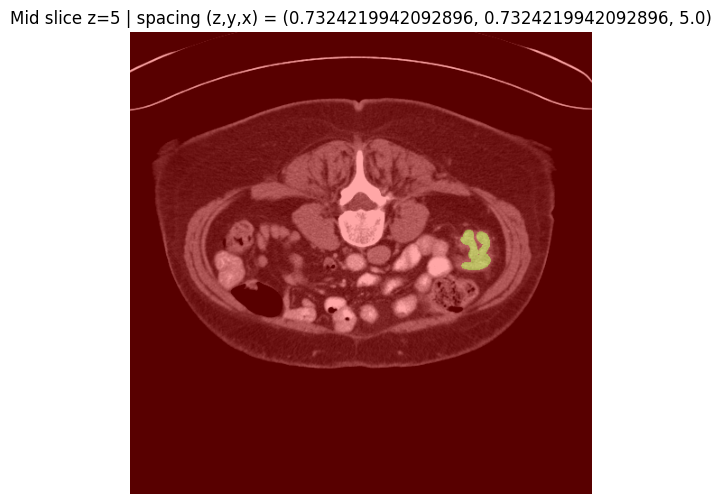

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 배치에서 하나만 꺼내기
imgs_b, gts_b, spacing_b = next(iter(test_loader))
img = imgs_b[0, 0].cpu().numpy()    # (D, H, W)  ← 첫 채널만 사용(3채널은 복제)
gt  = gts_b[0].cpu().numpy()        # (D, H, W)
spacing = spacing_b[0].cpu().numpy()

D, H, W = img.shape
mid = D // 2

# 보기 좋은 대비를 위해 로버스트 정규화(1~99 퍼센타일)
vmin, vmax = np.percentile(img, (1, 99))

plt.figure(figsize=(6, 6))
plt.imshow(img[mid], cmap="gray", vmin=vmin, vmax=vmax)
plt.imshow(gt[mid], cmap="autumn", alpha=0.35)  # 오버레이
plt.title(f"Mid slice z={mid} | spacing (z,y,x) = {tuple(spacing)}")
plt.axis("off")
plt.show()


2) 여러 슬라이스 그리드로 보기

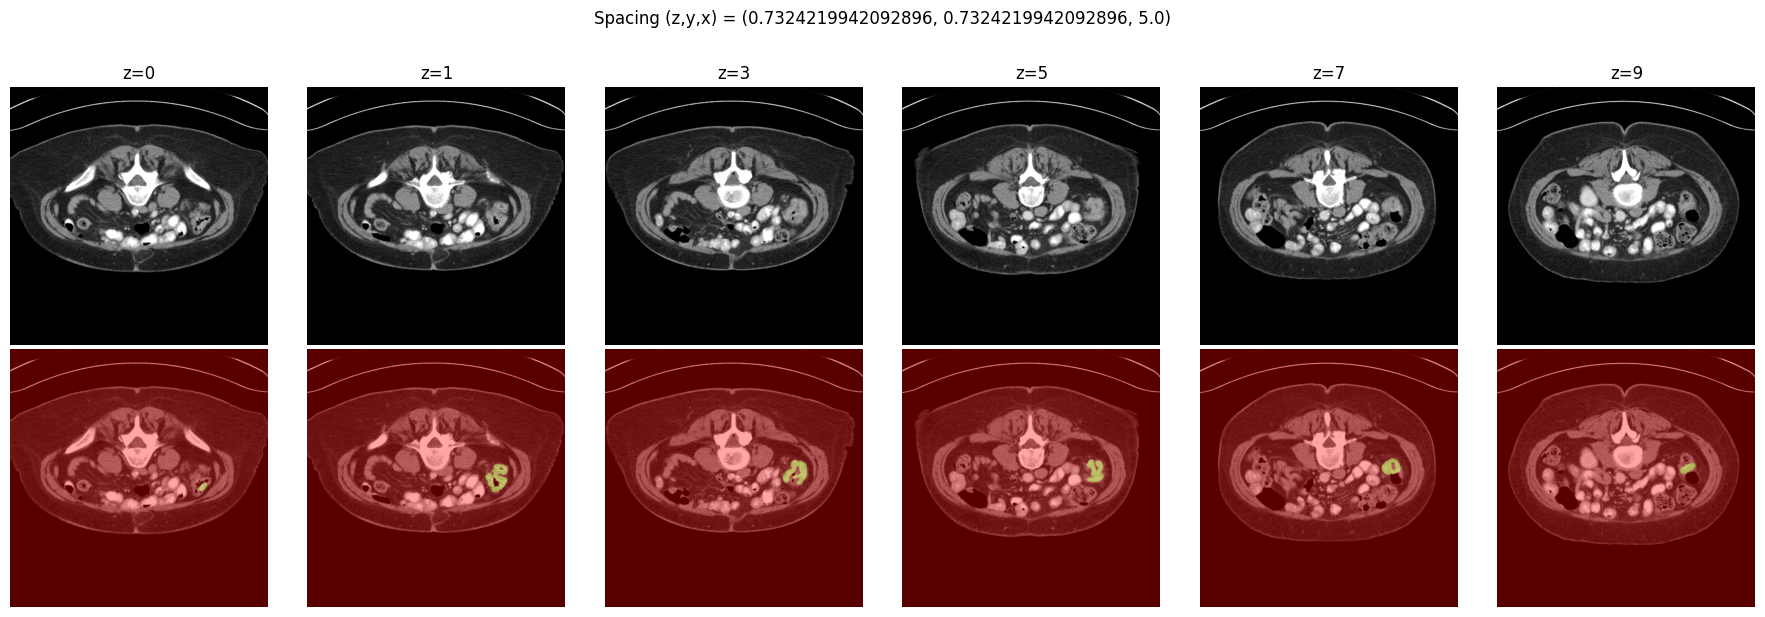

In [11]:
k = min(6, D)                              # 최대 6장
indices = np.linspace(0, D-1, k, dtype=int)

fig, axes = plt.subplots(2, k, figsize=(3*k, 6))
for j, idx in enumerate(indices):
    # 원본
    axes[0, j].imshow(img[idx], cmap="gray", vmin=vmin, vmax=vmax)
    axes[0, j].set_title(f"z={idx}")
    axes[0, j].axis("off")
    # 오버레이
    axes[1, j].imshow(img[idx], cmap="gray", vmin=vmin, vmax=vmax)
    axes[1, j].imshow(gt[idx], cmap="autumn", alpha=0.35)
    axes[1, j].axis("off")

fig.suptitle(f"Spacing (z,y,x) = {tuple(spacing)}", y=1.02)
plt.tight_layout()
plt.show()


### 4. 결과 해석

- `imgs.shape`: (B, 3, D, H, W) → RGB 3채널로 확장된 3D 볼륨  

- `gts.shape`: (B, D, H, W) → 3D segmentation mask  

- `spacing`: voxel 크기(mm) (z, y, x)

